# Purpose
- explore this restaurent forecasting
    - https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting/data
    - It covers two restaurents booking systems
        - air
        - hpg
    - It contains
        - reservation data
        - basic store info (location + genre)
        - join table for some restaurents
        - Actual visitor data (only air restaurents)
        - (japanese holidays).
    - The tasks is to predict actual visitors for a number of retaurents



In [29]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from fbprophet import Prophet

%matplotlib inline

Importing plotly failed. Interactive plots will not work.


In [5]:
# Get data
!kaggle competitions download -c recruit-restaurant-visitor-forecasting
!unzip -o recruit-restaurant-visitor-forecasting.zip -d data
!mkdir data
files = ['air_reserve.csv.zip','air_store_info.csv.zip','air_visit_data.csv.zip','date_info.csv.zip','hpg_reserve.csv.zip','hpg_store_info.csv.zip','sample_submission.csv.zip','store_id_relation.csv.zip']
for file in files:
    !unzip -o data/{file} -d data
    !rm data/{file}

 96%|████████████████████████████████████▌ | 25.0M/26.0M [00:02<00:00, 8.88MB/s]
100%|██████████████████████████████████████| 26.0M/26.0M [00:02<00:00, 9.99MB/s]
Archive:  recruit-restaurant-visitor-forecasting.zip
  inflating: data/air_reserve.csv.zip  
  inflating: data/air_store_info.csv.zip  
  inflating: data/air_visit_data.csv.zip  
  inflating: data/date_info.csv.zip  
  inflating: data/hpg_reserve.csv.zip  
  inflating: data/hpg_store_info.csv.zip  
  inflating: data/sample_submission.csv.zip  
  inflating: data/store_id_relation.csv.zip  
mkdir: data: File exists
Archive:  data/air_reserve.csv.zip
  inflating: data/air_reserve.csv    
Archive:  data/air_store_info.csv.zip
  inflating: data/air_store_info.csv  
Archive:  data/air_visit_data.csv.zip
  inflating: data/air_visit_data.csv  
Archive:  data/date_info.csv.zip
  inflating: data/date_info.csv      
Archive:  data/hpg_reserve.csv.zip
  inflating: data/hpg_reserve.csv    
Archive:  data/hpg_store_info.csv.zip
  inflating:

In [8]:
data = {
    'air_reserve': pd.read_csv('data/air_reserve.csv'),
    'air_store_info': pd.read_csv('data/air_store_info.csv'),
    'air_visit_data': pd.read_csv('data/air_visit_data.csv'),
    'date_info': pd.read_csv('data/date_info.csv'),
    'hpg_reserve': pd.read_csv('data/hpg_reserve.csv'),
    'hpg_store_info': pd.read_csv('data/hpg_store_info.csv'),
    'sample_submission': pd.read_csv('data/sample_submission.csv'),
    'store_id_relation': pd.read_csv('data/store_id_relation.csv'),
}

## Focus on just using past data to predict new 

In [15]:
history = data["air_visit_data"]

# see data format
display(history.head(3))

# get unique stores
stores = pd.unique(history["air_store_id"])
print("Number of stores: %f" % (len(stores),))


,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29


Number of stores: 829.000000


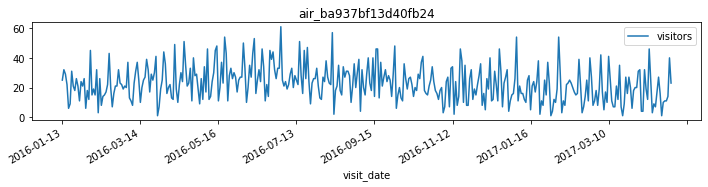

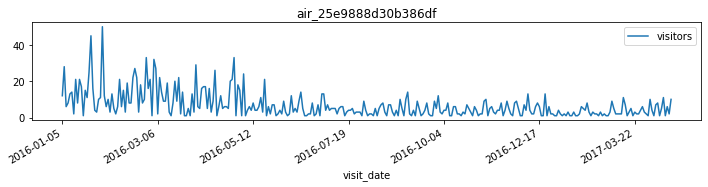

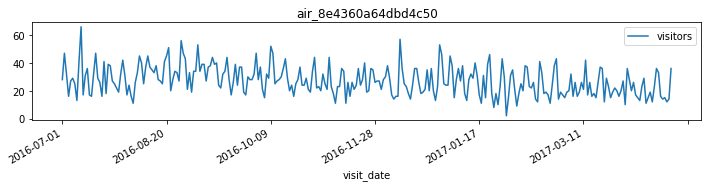

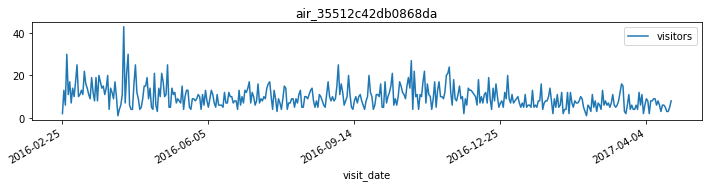

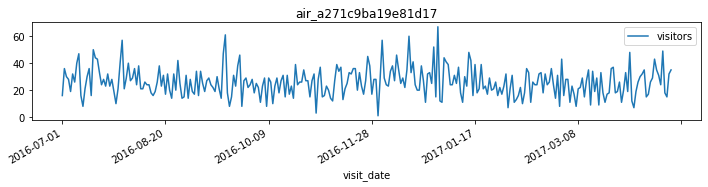

In [26]:
for idx in stores[:5]:
    history[history["air_store_id"]==idx].plot(
        x="visit_date"
        ,y="visitors"
        ,title=idx)
    fig = plt.gcf() 
    fig.set_size_inches(12,2)
    fig.autofmt_xdate()

In [41]:
# fit them with prophet
history["ds"] = pd.to_datetime(history['visit_date'])
history["y"] = history['visitors']

history.dtypes


air_store_id            object
visit_date              object
visitors                 int64
ds              datetime64[ns]
y                        int64
dtype: object

In [51]:
model1=Prophet(interval_width=0.95) 

m = Prophet(yearly_seasonality = True, seasonality_prior_scale=0.1)
m.fit(df=history[history["air_store_id"]==stores[0]][:-100])
future = m.make_future_dataframe(periods=100)
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [47]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

Text(0, 0.5, 'visitors')

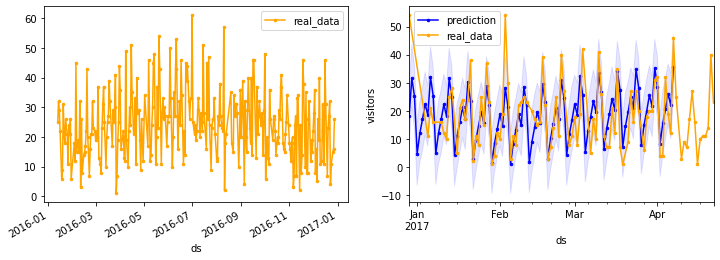

In [89]:
fig,ax = plt.subplots(1,2)
fig.set_size_inches(12,4)

history[history["air_store_id"]==stores[0]][:-100].plot(x="ds",y="y",ax=ax[0],style='.',color="orange",linestyle="-",markersize="5",label="real_data")


ax[1].fill_between(forecast.ds, (forecast.yhat_lower), (forecast.yhat_upper), color='b', alpha=.1)

forecast[-100:].plot(x="ds",y="yhat",ax=ax[1],style=".",markersize="5",linestyle="-",color='b',label="prediction")
history[history["air_store_id"]==stores[0]][-100:].plot(x="ds",y="y",ax=ax[1],style='.',color="orange",linestyle="-",markersize="5",label="real_data")
plt.ylabel("visitors")

## do systematic predictions for submissions

In [79]:
 data['sample_submission'].head(2)

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0
1,air_00a91d42b08b08d9_2017-04-24,0


In [75]:
df_submit_dates = data['sample_submission']["id"].apply(lambda x: x[-10:]).unique()

In [97]:
df_submit_dates

array(['2017-04-23', '2017-04-24', '2017-04-25', '2017-04-26',
       '2017-04-27', '2017-04-28', '2017-04-29', '2017-04-30',
       '2017-05-01', '2017-05-02', '2017-05-03', '2017-05-04',
       '2017-05-05', '2017-05-06', '2017-05-07', '2017-05-08',
       '2017-05-09', '2017-05-10', '2017-05-11', '2017-05-12',
       '2017-05-13', '2017-05-14', '2017-05-15', '2017-05-16',
       '2017-05-17', '2017-05-18', '2017-05-19', '2017-05-20',
       '2017-05-21', '2017-05-22', '2017-05-23', '2017-05-24',
       '2017-05-25', '2017-05-26', '2017-05-27', '2017-05-28',
       '2017-05-29', '2017-05-30', '2017-05-31'], dtype=object)

In [96]:
"2017-04-23" in df_submit_dates

True

### Example single predict

In [92]:
# Example with one. 

model1=Prophet(interval_width=0.95) 

m = Prophet(yearly_seasonality = True, seasonality_prior_scale=0.1)
m.fit(df=history[history["air_store_id"]==stores[0]])
future = m.make_future_dataframe(periods=60)
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [101]:
stores[0]

'air_ba937bf13d40fb24'

In [103]:
pred_raw = forecast[forecast["ds"].isin(df_submit_dates)]
pred_raw.head()


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
391,2017-04-23,19.530611,-7.053238,13.985350,19.530611,19.530611,-15.429195,-15.429195,-15.429195,-13.793193,-13.793193,-13.793193,-1.636003,-1.636003,-1.636003,0.0,0.0,0.0,4.101415
392,2017-04-24,19.522284,0.458636,21.150011,19.522284,19.522284,-8.615745,-8.615745,-8.615745,-7.088814,-7.088814,-7.088814,-1.526931,-1.526931,-1.526931,0.0,0.0,0.0,10.906539
393,2017-04-25,19.513958,5.993874,26.569083,19.513958,19.513958,-3.651425,-3.651425,-3.651425,-2.260730,-2.260730,-2.260730,-1.390695,-1.390695,-1.390695,0.0,0.0,0.0,15.862533
394,2017-04-26,19.505631,11.281113,32.864100,19.505631,19.505631,1.785489,1.785489,1.785489,3.012430,3.012430,3.012430,-1.226942,-1.226942,-1.226942,0.0,0.0,0.0,21.291120
395,2017-04-27,19.497305,8.325111,28.671048,19.497305,19.497305,-1.481274,-1.481274,-1.481274,-0.445446,-0.445446,-0.445446,-1.035828,-1.035828,-1.035828,0.0,0.0,0.0,18.016030


In [126]:

ids = stores[0] + "_" + pred_raw["ds"].astype(str)
visitors = pred_raw["yhat"].astype(int)

out = pd.merge(ids,visitors,left_index=True,right_index=True)

out.head()

,ds,yhat
391,air_ba937bf13d40fb24_2017-04-23,4
392,air_ba937bf13d40fb24_2017-04-24,10
393,air_ba937bf13d40fb24_2017-04-25,15
394,air_ba937bf13d40fb24_2017-04-26,21
395,air_ba937bf13d40fb24_2017-04-27,18


In [129]:
# and merge them all
pd.concat([out,out], axis=0)


,ds,yhat
391,air_ba937bf13d40fb24_2017-04-23,4
392,air_ba937bf13d40fb24_2017-04-24,10
393,air_ba937bf13d40fb24_2017-04-25,15
394,air_ba937bf13d40fb24_2017-04-26,21
395,air_ba937bf13d40fb24_2017-04-27,18
...,...,...
425,air_ba937bf13d40fb24_2017-05-27,30
426,air_ba937bf13d40fb24_2017-05-28,10
427,air_ba937bf13d40fb24_2017-05-29,16
428,air_ba937bf13d40fb24_2017-05-30,21


# Putting it together to predict all

In [156]:
import time
model1=Prophet(interval_width=0.95) 

out_full = None

start_time = time.time()
total_start_time = start_time
for store_id in stores:
    print(store_id)
    data = history[history["air_store_id"]==store_id]
    if sum(data['y'].notnull()) < 3:
        break
    m = Prophet(yearly_seasonality = True, seasonality_prior_scale=0.1)
    m.fit(df = data)
    future = m.make_future_dataframe(periods=60)
    forecast = m.predict(future)
    pred_raw = forecast[forecast["ds"].isin(df_submit_dates)]

    ids = stores[0] + "_" + pred_raw["ds"].astype(str)
    visitors = pred_raw["yhat"].astype(int)

    out = pd.merge(ids,visitors,left_index=True,right_index=True)
        
    if out_full is None:
        # first time overwrite
        out_full = out
    else:
        # Append 
        out_full = pd.concat([out_full,out], axis=0)
    end_time =  time.time()
    print('time in seconds: ' + str(end_time - start_time))
    start_time = end_time


print('TOTAL, time in seconds: ' + str(end_time - total_start_time))


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


air_ba937bf13d40fb24


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


time in seconds: 5.199073076248169
air_25e9888d30b386df


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


time in seconds: 3.9661200046539307
air_8e4360a64dbd4c50


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


time in seconds: 3.6545069217681885
air_35512c42db0868da


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


time in seconds: 4.1502320766448975
air_a271c9ba19e81d17


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


time in seconds: 4.921764135360718
air_fd6aac1043520e83


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


time in seconds: 4.251178026199341
air_64d4491ad8cdb1c6


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


time in seconds: 5.16701078414917
air_cf22e368c1a71d53


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


time in seconds: 3.276658058166504
air_f3f9824b7d70c3cf


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


time in seconds: 3.5648629665374756
air_820d1919cbecaa0a


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


time in seconds: 3.149245023727417
air_9ae7081cb77dc51e


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


time in seconds: 3.5092060565948486
air_d69b08a175bc0387


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


time in seconds: 3.2134170532226562
air_ee3a01f0c71a769f


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


time in seconds: 5.003870964050293
air_9438d67241c81314


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


time in seconds: 4.326756000518799
air_3e93f3c81008696d


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


time in seconds: 3.1242189407348633
air_cb935ff8610ba3d3


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


time in seconds: 3.22788405418396
air_9bf595ef095572fb


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


time in seconds: 3.901655912399292
air_876d7a23c47811cb


KeyboardInterrupt: 

,air_store_id,visit_date,visitors,ds,y
count,320,320,320,320,320
unique,1,1,1,1,1
top,False,False,False,False,False
freq,320,320,320,320,320


In [155]:
out_full is None

False